## This notebook focuses on the second part of the PatientOmics framework:

The aim is to organizing clinical time-series data for analysis and visualization, inwhich we perform the following tasks:

1. Execute a script to generate the initial matrix containing clinical features for 116 patients, specifically on the first day of hospitalization.

2. Visualize the correlation among laboratory features for potential long COVID patients (N = 116) on their first day of hospitalization, by:
        a. Grouping features based on their laboratory families.
        b. Sorting features by their average similarity distances.

3. Create a cluster map to visualize data patterns among potential long COVID patients (N = 116).

4. Structuring this notebook to add the data preparation functions to transform a pandas dataframe into X and y numpy arrays that can be used to create a TSDataset.
    - https://timeseriesai.github.io/tsai/data.preparation.html



https://github.com/tslearn-team/tslearn

https://github.com/timeseriesAI/tsai

https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/15_PatchTST_a_new_transformer_for_LTSF.ipynb

    

In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

## Get the clinical features for all patients at one time point (e.g. 1st day of hospitalization)

In [2]:
## Get the clinical features for all patients at one time point (e.g. 1st day of hospitalization)

import os
import pandas as pd

# Read the list of unique patient IDs
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, '116_plcp_mv_pseudoid_pid.csv')
# filename = os.path.join(dir_path, 'deceased_patients_pseudoid_pid.csv')
df = pd.read_csv(filename, sep=',', header=0)

# Initialize an empty list to store patient DataFrames
patient_dfs = []

## Set the day to be selected
days_col = 60  

# Iterate through the patient IDs
for patient_id in df['pseudoid_pid']:
    dir_lab_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/06_clinical_data/lab_data_features/'
    filename = os.path.join(dir_lab_path, f'patient_{patient_id}.csv')

    try:
        # Read the CSV file into a DataFrame for each patient
        df_lab = pd.read_csv(filename, sep=',', header=0)

        # Get the row features for a specific day in 'days' column (e.g., 'days' == 0)
        df_lab_selected_day = df_lab[df_lab['days'] == days_col].copy()

        # Add a column 'patient_id' into the df_lab_selected_day
        df_lab_selected_day['patient_id'] = patient_id

        # Append the patient DataFrame to the list
        patient_dfs.append(df_lab_selected_day)

    except Exception as e:
    # except FileNotFoundError:
        print(f"Error reading patient {patient_id}: {str(e)}")
        continue

# Concatenate all patient DataFrames into one
collection_df = pd.concat(patient_dfs, ignore_index=True)

# Save the resulting DataFrame as a CSV file
output_csv_path = dir_path + '116_plcp_lab_markers_day-' + str(days_col) +'.csv'
# output_csv_path = dir_path + 'deceased_patients_day-' + str(days_col) +'.csv'
collection_df.to_csv(output_csv_path, index=False)

## Add data imputation for missing values (e.g., mean, median, mode, etc.) using sklearn.impute.SimpleImputer, according to the day before and after the missing value


In [1]:
## Baseline method for data imputation for missing values from a range of days


import os
import pandas as pd

def impute_missing_values(df_lab_selected_day, df_lab_days, columns_to_impute):
    """Function for data imputation using substitution method"""

    imputed_values = []  # Store imputed values
    
    for column in columns_to_impute:
        if not df_lab_selected_day[column].isna().all():
            for index, row in df_lab_selected_day.iterrows():
                if pd.isna(row[column]):
                    # Find the nearest available value from days after the missing day
                    next_day_values = df_lab_days[df_lab_days['days'] > row['days']].sort_values(by='days')
                    if not next_day_values.empty:
                        next_day_value = next_day_values.iloc[0][column]
                        df_lab_selected_day.at[index, column] = next_day_value
                        imputed_values.append(next_day_value)
                    else:
                        # If no values are available from days after, use the nearest available value from days before
                        prev_day_values = df_lab_days[df_lab_days['days'] < row['days']].sort_values(by='days', ascending=False)
                        if not prev_day_values.empty:
                            prev_day_value = prev_day_values.iloc[0][column]
                            df_lab_selected_day.at[index, column] = prev_day_value
                            imputed_values.append(prev_day_value)
    
    return df_lab_selected_day, imputed_values

# # Read the list of unique patient IDs
# dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
# # filename = os.path.join(dir_path, '116_plcp_mv_pseudoid_pid.csv')
# filename = os.path.join(dir_path, 'deceased_patients_pseudoid_pid.csv')
# df = pd.read_csv(filename, sep=',', header=0)


# Read the list of unique patient IDs
dir_path = '/data/01_multiomics/02_long_covid_study/04_lung_function_tests/03_FirstAnalysis/01_pairing_long_covid_clinical_data/'
# filename = os.path.join(dir_path, '116_plcp_mv_pseudoid_pid.csv')
filename = os.path.join(dir_path, '03_LongCovid_IDS_keys_clinical_data.csv')
df = pd.read_csv(filename, sep=';', header=0)


# Initialize an empty list to store patient DataFrames
patient_dfs = []

# Set the day range to be selected
init_day = 0
end_day = 60

# Initialize a list to store all imputed values
all_imputed_values = []

# Iterate through the patient IDs
for patient_id in df['pseudoid_pid']:
    dir_lab_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/06_clinical_data/lab_data_features/'
    filename = os.path.join(dir_lab_path, f'patient_{patient_id}.csv')

    try:
        # Read the CSV file into a DataFrame for each patient
        df_lab = pd.read_csv(filename, sep=',', header=0)

        # Get the row features from 'df_lab' for the selected day range
        df_lab_days = df_lab[df_lab['days'].between(init_day, end_day)].copy()

        # Get the columns to impute from the dataframe df_lab_days
        columns_to_impute = df_lab_days.columns[2:-1].tolist()

        # Iterate through the selected days
        for selected_day in range(init_day, end_day + 1):
            # Get the row features for a specific day in 'days' column
            df_lab_day_selected = df_lab_days[df_lab_days['days'] == selected_day].copy()

            # Apply data imputation for the selected day
            df_lab_day_selected, imputed_values = impute_missing_values(df_lab_day_selected, df_lab_days, columns_to_impute)
            all_imputed_values.extend(imputed_values)  # Append imputed values to the list

            # Add a column 'patient_id' into the df_lab_day_selected
            df_lab_day_selected['patient_id'] = patient_id

            # Append the patient DataFrame to the list
            patient_dfs.append(df_lab_day_selected)

    except Exception as e:
        print(f"Error reading patient {patient_id}: {str(e)}")
        continue

# Concatenate all patient DataFrames into one
collection_df = pd.concat(patient_dfs, ignore_index=True)

# # Save the resulting DataFrame as a CSV file
# # output_csv_path = os.path.join(dir_path, f'116_plcp_lab_markers_day_Imputed-{init_day}_to_{end_day}.csv')
# output_csv_path = os.path.join(dir_path, f'deceased_lab_markers_day_Imputed-{init_day}_to_{end_day}.csv')
# collection_df.to_csv(output_csv_path, index=False)

# # Save the imputed values to a separate file if needed
# # imputed_values_file = os.path.join(dir_path, f'116_plcp_lab_imputed_values.csv')
# imputed_values_file = os.path.join(dir_path, f'deceased_lab_imputed_values.csv')
# pd.Series(all_imputed_values).to_csv(imputed_values_file, index=False, header=['Imputed_Values'])



# output_csv_path = os.path.join(dir_path, f'116_plcp_lab_markers_day_Imputed-{init_day}_to_{end_day}.csv')
output_csv_path = os.path.join(dir_path, f'LongCovid_IDS_keys_clinical_data-{init_day}_to_{end_day}.csv')
collection_df.to_csv(output_csv_path, index=False)

# Save the imputed values to a separate file if needed
# imputed_values_file = os.path.join(dir_path, f'116_plcp_lab_imputed_values.csv')
imputed_values_file = os.path.join(dir_path, f'LongCovid_IDS_keys_clinical_data.csv')
pd.Series(all_imputed_values).to_csv(imputed_values_file, index=False, header=['Imputed_Values'])



KeyError: 'pseudoid_pid'

### Grouped features based on their laboratory family

/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


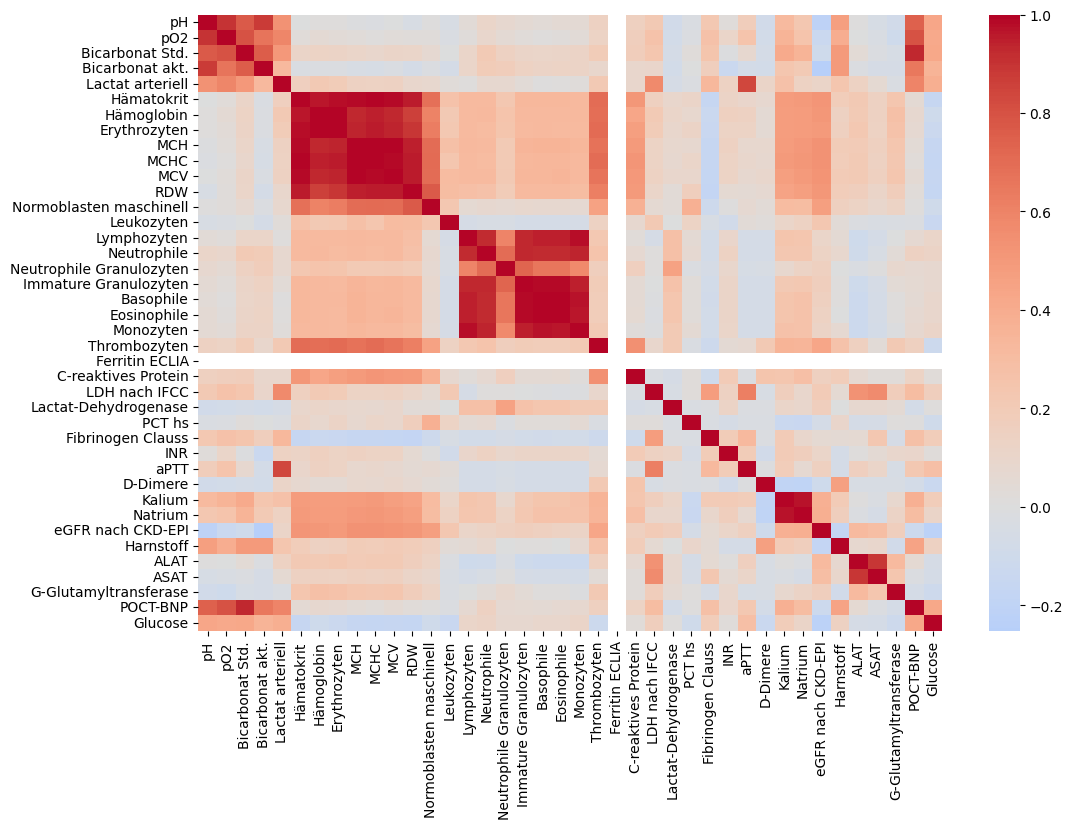

In [8]:
### Grouped features based on their laboratory family

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS


## Set the day range to be selected
init_day = 7
# end_day = 2

## Load the list of laboratory features
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_parameter_grouping.csv')
df_lab_features = pd.read_csv(filename, sep=',', header=0)

## Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, f'116_plcp_lab_markers_day-{init_day}.csv')
# filename = os.path.join(dir_path, f'deceased_patients_day-{init_day}.csv')
# filename = os.path.join(dir_path, f'116_plcp_lab_markers_day_Imputed-{init_day}_to_{end_day}_starting.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

## Set the 'df' columns in the order of the 'df_lab_features'
df = df.reindex(columns=df_lab_features['lab_parameter'].tolist())

## Set the df without the first two columns
df = df.iloc[:, 2:].copy()

## Set NaN values to 0
df = df.fillna(-1)

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Calculate pairwise distances using Euclidean distance
similarities = pairwise_distances(scaled_data, metric='euclidean')

# Multidimensional scaling
seed = np.random.RandomState(seed=3)
mds = MDS(n_components=2, max_iter=5000, eps=1e-12, random_state=seed, dissimilarity='precomputed', n_jobs=1, metric=False)
pos = mds.fit_transform(similarities)

# Features as a heatmap
corr = df.corr()

# Set up the matplotlib figure, adjust size
plt.figure(figsize=(12, 8))

# Draw the heatmap using seaborn
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f", center=0)

plt.show()

### Sort features based on their average similarity distances

/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Axes: >

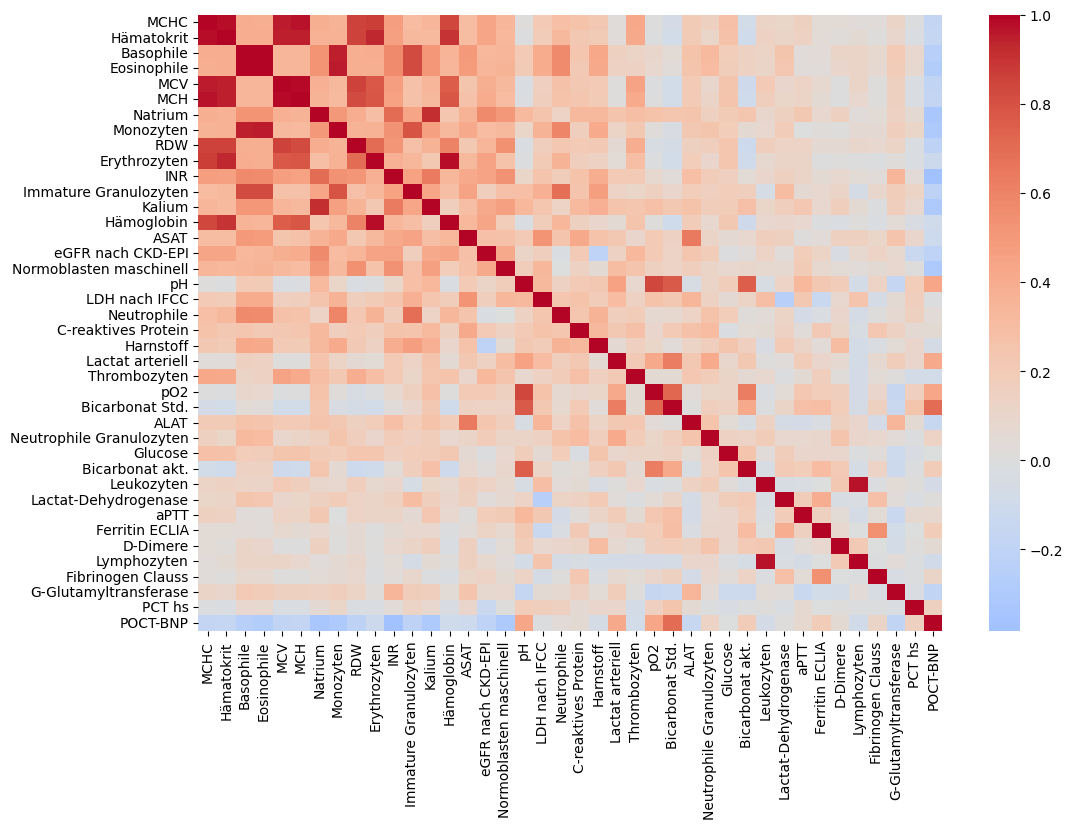

In [3]:
### Sort features based on their average similarity distances

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS


## Set the day range to be selected
init_day = 0
# end_day = 2

## Load the list of laboratory features
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_parameter_grouping.csv')
df_lab_features = pd.read_csv(filename, sep=',', header=0)

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
# filename = os.path.join(dir_path, 'lab_data_exploration.csv')
# filename = os.path.join(dir_path, f'116_plcp_lab_markers_day_Imputed-{days_col}.csv')
# filename = os.path.join(dir_path, f'116_plcp_lab_markers_day_Imputed-{init_day}_to_{end_day}_starting.csv')
filename = os.path.join(dir_path, f'116_plcp_lab_markers_day-{init_day}.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

## Set the 'df' columns in the order of the 'df_lab_features'
df = df.reindex(columns=df_lab_features['lab_parameter'].tolist())

## Set the df without the first two columns
df = df.iloc[:, 2:].copy()

## Set NaN values to 0
df = df.fillna(-1)

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Calculate pairwise distances using Euclidean distance
similarities = pairwise_distances(scaled_data.T, metric='euclidean')  # Transpose to get feature distances

# Calculate average similarity distance for each feature
average_distances = np.mean(similarities, axis=0)

# Sort features based on their average similarity distances
sorted_indices = np.argsort(average_distances)
sorted_features = df.columns[sorted_indices]

# Reorder the dataframe columns based on sorted features
sorted_df = df[sorted_features]

# Multidimensional scaling
seed = np.random.RandomState(seed=3)
mds = MDS(n_components=2, max_iter=5000, eps=1e-12, random_state=seed, dissimilarity='precomputed', n_jobs=1, metric=False)
pos = mds.fit_transform(similarities)

# Features as a heatmap
corr = sorted_df.corr()

# Set up the matplotlib figure, adjust size
plt.figure(figsize=(12, 8))

# Draw the heatmap using seaborn
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f", center=0)


## Cluster map to visualize data patterns among potential long COVID patients (N = 116)

Number of NaN values: 0
Number of infinite values: 0


/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


<Figure size 1500x1000 with 0 Axes>

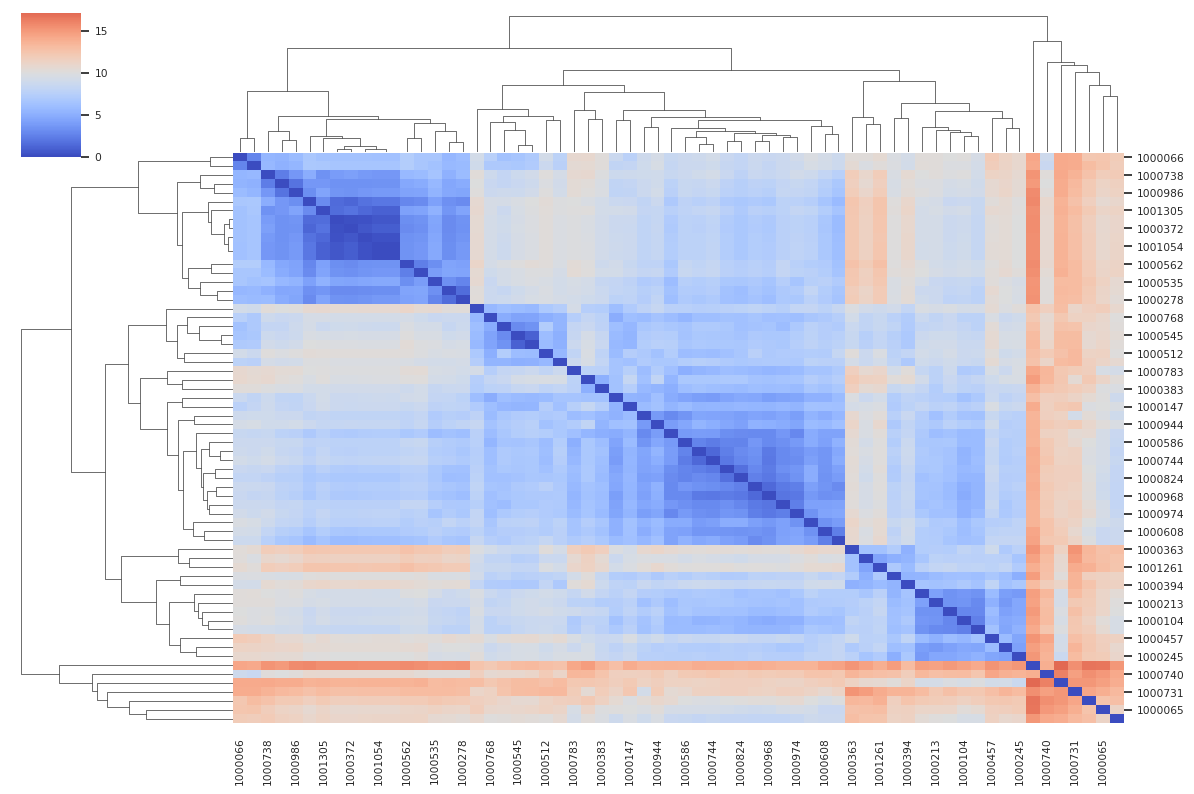

In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import euclidean_distances
from sklearn.preprocessing import StandardScaler



## Set the day range to be selected
init_day = 7
# end_day = 2

## Load the list of laboratory features
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_parameter_grouping.csv')
df_lab_features = pd.read_csv(filename, sep=',', header=0)

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
# filename = os.path.join(dir_path, 'lab_data_exploration.csv')
# filename = os.path.join(dir_path, f'116_plcp_lab_markers_day_Imputed-{days_col}.csv')
# filename = os.path.join(dir_path, f'116_plcp_lab_markers_day_Imputed-{init_day}_to_{end_day}_starting.csv')
filename = os.path.join(dir_path, f'116_plcp_lab_markers_day-{init_day}.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

## Set the 'df' columns in the order of the 'df_lab_features'
df = df.reindex(columns=df_lab_features['lab_parameter'].tolist())

## Set the df without the first two columns
df = df.iloc[:, 2:].copy()

## Set NaN values to 0
df = df.fillna(-1)

# Extract the feature columns and sample data
feature_names = df.columns
samples = df.values

# Extract patients ids
patient_ids = df.index.values

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Calculate pairwise Euclidean distances
similarities = euclidean_distances(scaled_samples)

# Debugging: Output non-finite values in the similarities matrix
nan_count = np.sum(np.isnan(similarities))
inf_count = np.sum(np.isinf(similarities))
print("Number of NaN values:", nan_count)
print("Number of infinite values:", inf_count)

# Replace NaN with infinity
similarities[np.isnan(similarities)] = np.inf

# Create a DataFrame with the similarities and feature names
similarities_df = pd.DataFrame(similarities, columns=patient_ids, index=patient_ids)

# Set up the matplotlib figure, make it big!
plt.figure(figsize=(15, 10))

# Create a cluster map using seaborn
sns.clustermap(similarities_df, cmap='coolwarm', method='average', metric='euclidean', figsize=(12, 8), center=10)

plt.show()

In [23]:
# import os
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler
# from scipy.cluster import hierarchy

# def hierarchical_clustering(df, method='average', metric='euclidean', figsize=(12, 8), center=10):
#     # Set NaN values to 0
#     df = df.fillna(0)

#     # Extract the feature columns and sample data
#     feature_names = df.columns
#     samples = df.values

#     # Extract patients ids
#     patient_ids = df.index.values

#     # Standardize the data before calculating distances
#     scaler = StandardScaler()
#     scaled_samples = scaler.fit_transform(samples)

#     # Calculate pairwise Euclidean distances
#     similarities = hierarchy.linkage(scaled_samples, method=method, metric=metric)

#     # Set up the matplotlib figure
#     plt.figure(figsize=figsize)

#     # Create a dendrogram with patients on the y-axis
#     hierarchy.dendrogram(similarities, labels=patient_ids, orientation='left', leaf_font_size=8)

#     # Show the dendrogram
#     plt.title(f'Hierarchical Clustering Dendrogram ({method}, {metric})')
#     plt.xlabel('Distance')
#     plt.ylabel('Patients')

#     plt.show()



# ## Set the day range to be selected
# init_day = 0
# end_day = 2

# ## Load the list of laboratory features
# dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
# filename = os.path.join(dir_path, 'lab_parameter_grouping.csv')
# df_lab_features = pd.read_csv(filename, sep=',', header=0)

# # Load data
# dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
# filename = os.path.join(dir_path, f'116_plcp_lab_markers_day-{init_day}.csv')
# df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# ## Set the 'df' columns in the order of the 'df_lab_features'
# df = df.reindex(columns=df_lab_features['lab_parameter'].tolist())

# ## Set the df without the first two columns
# df = df.iloc[:, 2:].copy()

# ## Set NaN values to 0
# df = df.fillna(-1)

# # Call the hierarchical_clustering function
# hierarchical_clustering(df, method='average', metric='euclidean', figsize=(12, 30), center=10)

In [1]:
#pip install pydendroheatmap
cd /pydendroheatmap
python setup.py install

SyntaxError: invalid syntax (1439735907.py, line 3)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy
import dendroheatmap as dhm

def hierarchical_clustering(df, method='average', metric='euclidean', figsize=(12, 8), center=10):
    # Set NaN values to 0
    df = df.fillna(0)

    # Extract the feature columns and sample data
    feature_names = df.columns
    samples = df.values

    # Extract patients ids
    patient_ids = df.index.values

    # Standardize the data before calculating distances
    scaler = StandardScaler()
    scaled_samples = scaler.fit_transform(samples)

    # Calculate pairwise Euclidean distances
    similarities = hierarchy.linkage(scaled_samples, method=method, metric=metric)

    # Create a hierarchical clustering dendrogram
    plt.figure(figsize=figsize)
    hierarchy.dendrogram(similarities, labels=patient_ids, orientation='left', leaf_font_size=8)
    plt.title(f'Hierarchical Clustering Dendrogram ({method}, {metric})')
    plt.xlabel('Distance')
    plt.ylabel('Patients')
    plt.show()

    # Create a dendroheatmap
    plt.figure(figsize=figsize)
    heatmap = dhm.DendroHeatMap(df, row_linkage=similarities, col_linkage=similarities)
    heatmap.plot(cbar=True, scale_axis='row', cmap='coolwarm', center=center)
    plt.title(f'Hierarchical Clustering DendroHeatMap ({method}, {metric})')
    plt.xlabel('Features')
    plt.show()

# Set the day range to be selected
init_day = 0
end_day = 2

# Load the list of laboratory features
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_parameter_grouping.csv')
df_lab_features = pd.read_csv(filename, sep=',', header=0)

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, f'116_plcp_lab_markers_day-{init_day}.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Set the 'df' columns in the order of the 'df_lab_features'
df = df.reindex(columns=df_lab_features['lab_parameter'].tolist())

# Set the df without the first two columns
df = df.iloc[:, 2:].copy()

# Set NaN values to 0
df = df.fillna(-1)

# Call the hierarchical_clustering function
hierarchical_clustering(df, method='average', metric='euclidean', figsize=(12, 30), center=10)


ModuleNotFoundError: No module named 'dendroheatmap'

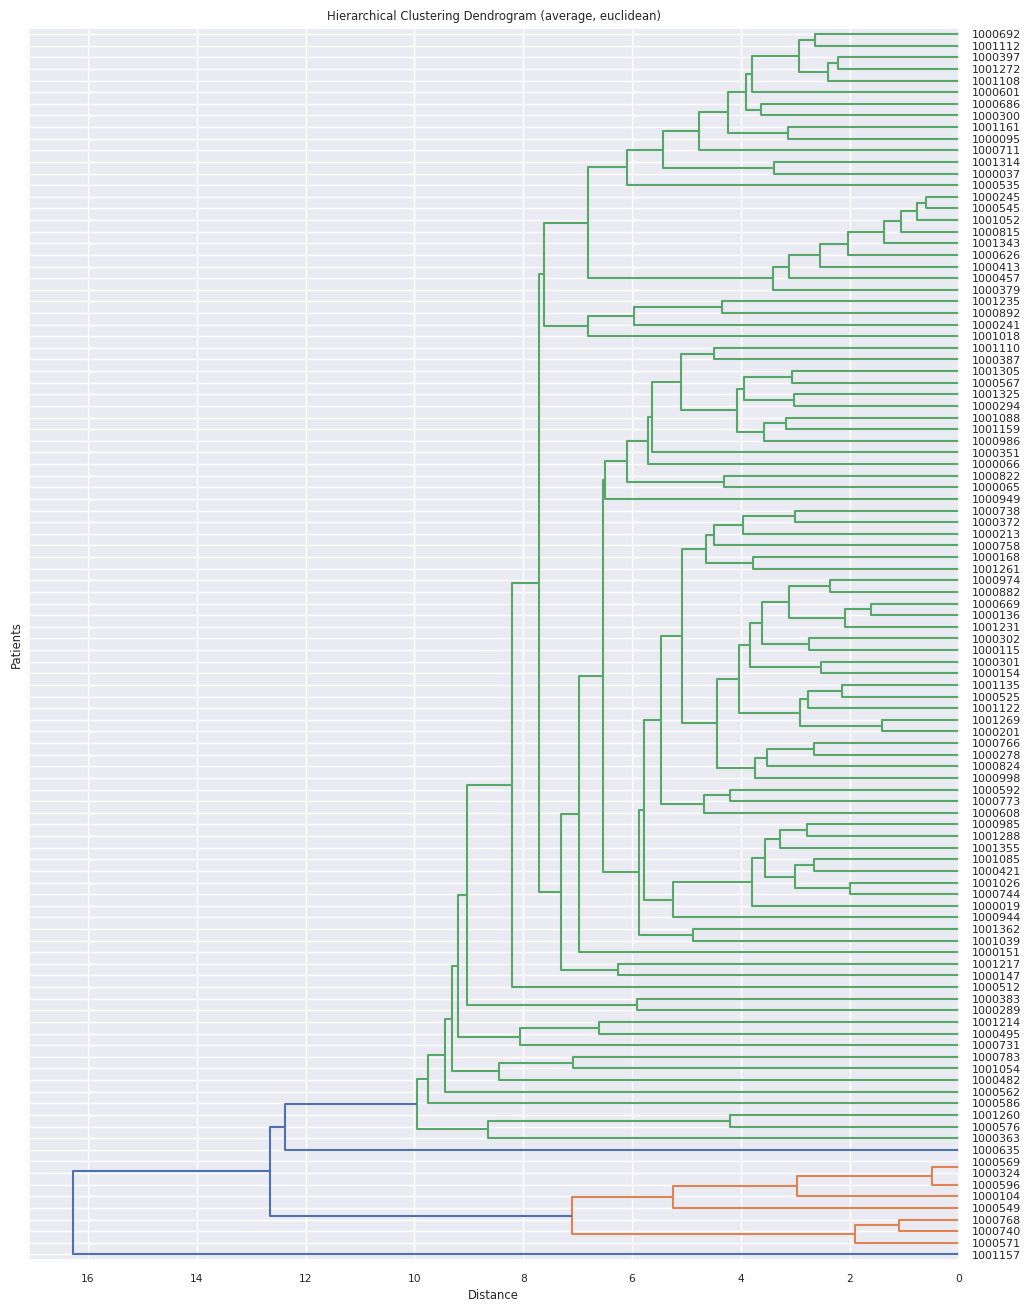

<Figure size 1200x1600 with 0 Axes>

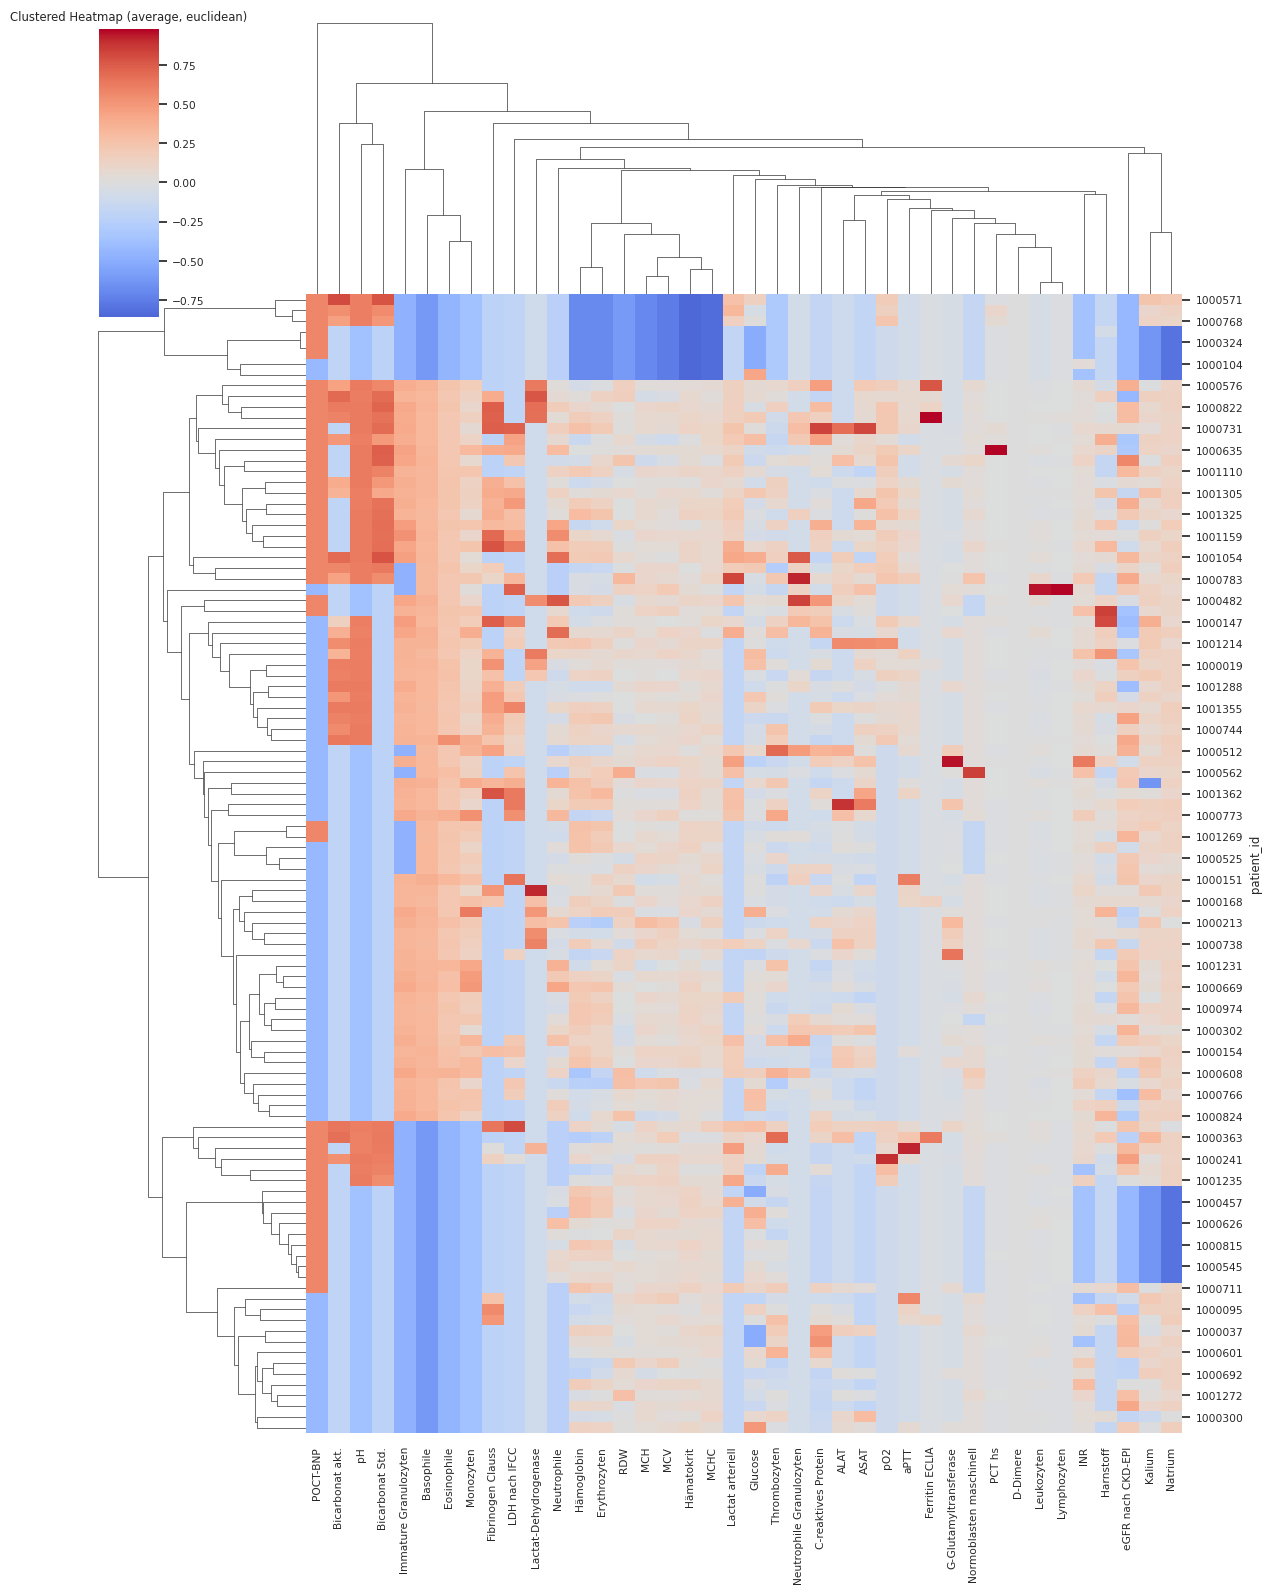

In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy
import seaborn as sns

def hierarchical_clustering(df, method='average', metric='euclidean', figsize=(12, 8), center=10):
    # Set NaN values to 0
    df = df.fillna(0)

    # Extract the feature columns and sample data
    feature_names = df.columns
    samples = df.values

    # Extract patients ids
    patient_ids = df.index.values

    # Standardize the data before calculating distances
    scaler = StandardScaler()
    scaled_samples = scaler.fit_transform(samples)

    # Calculate pairwise Euclidean distances
    similarities = hierarchy.linkage(scaled_samples, method=method, metric=metric)

    # Create a hierarchical clustering dendrogram
    plt.figure(figsize=figsize)
    hierarchy.dendrogram(similarities, labels=patient_ids, orientation='left', leaf_font_size=8)
    plt.title(f'Hierarchical Clustering Dendrogram ({method}, {metric})')
    plt.xlabel('Distance')
    plt.ylabel('Patients')
    plt.show()

    # Create a clustered heatmap using seaborn
    sns.set(font_scale=0.7)
    plt.figure(figsize=figsize)
    sns.clustermap(df, method=method, metric=metric, cmap='coolwarm', figsize=figsize, center=center)
    plt.title(f'Clustered Heatmap ({method}, {metric})')
    plt.show()

# Set the day range to be selected
init_day = 0
# end_day = 2

# Load the list of laboratory features
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_parameter_grouping-COPY.csv')
df_lab_features = pd.read_csv(filename, sep=',', header=0)

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, f'116_plcp_lab_markers_day-{init_day}.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Set the 'df' columns in the order of the 'df_lab_features'
df = df.reindex(columns=df_lab_features['lab_parameter'].tolist())

# Set the df without the first two columns
df = df.iloc[:, 2:].copy()

# Set NaN values to 0
df = df.fillna(-1)

## Normalize the data
df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

# Call the hierarchical_clustering function
hierarchical_clustering(df, method='average', metric='euclidean', figsize=(12, 16), center=0)

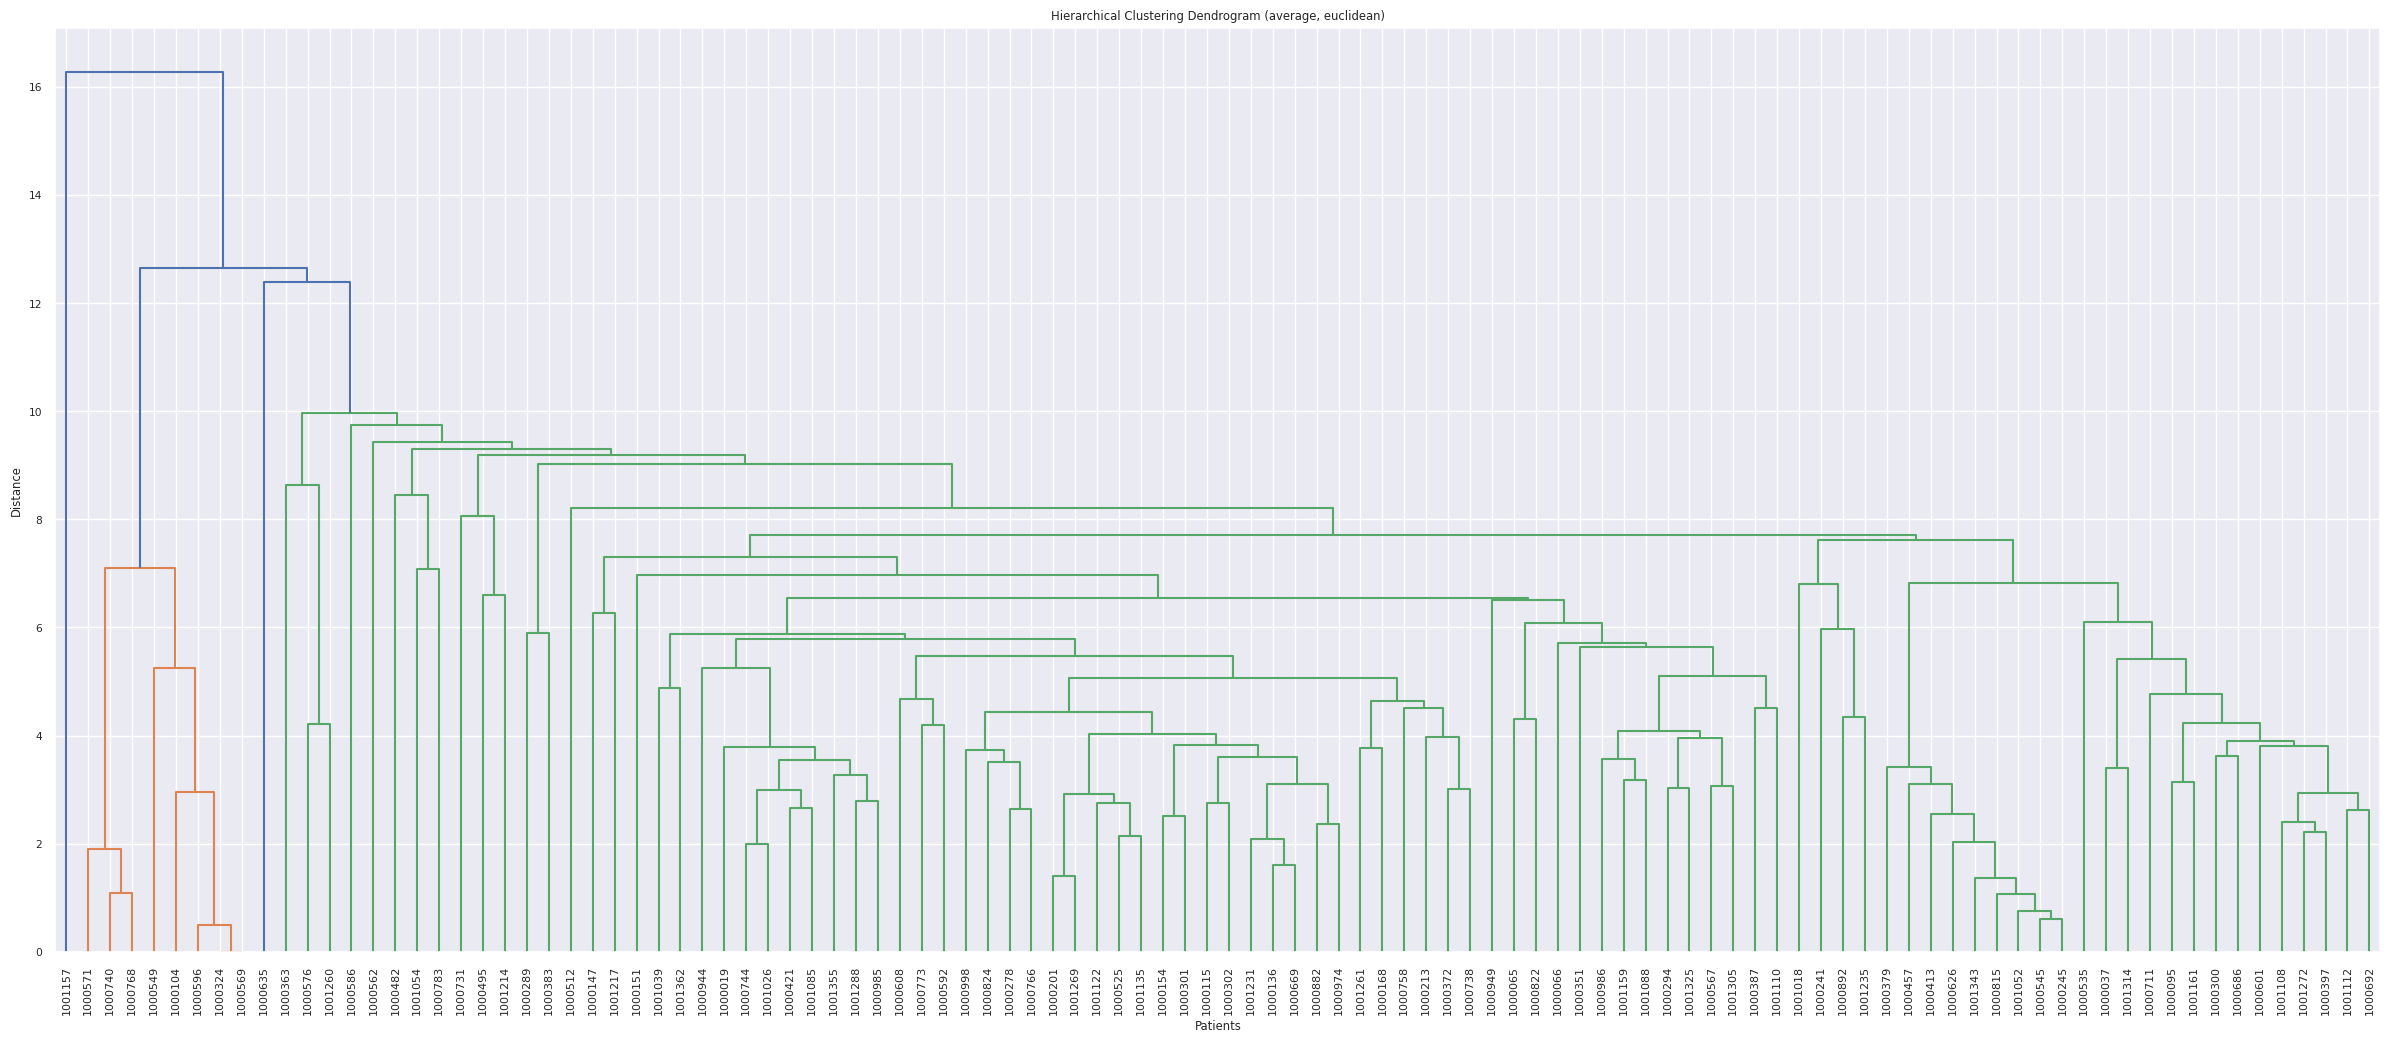

<Figure size 3000x1200 with 0 Axes>

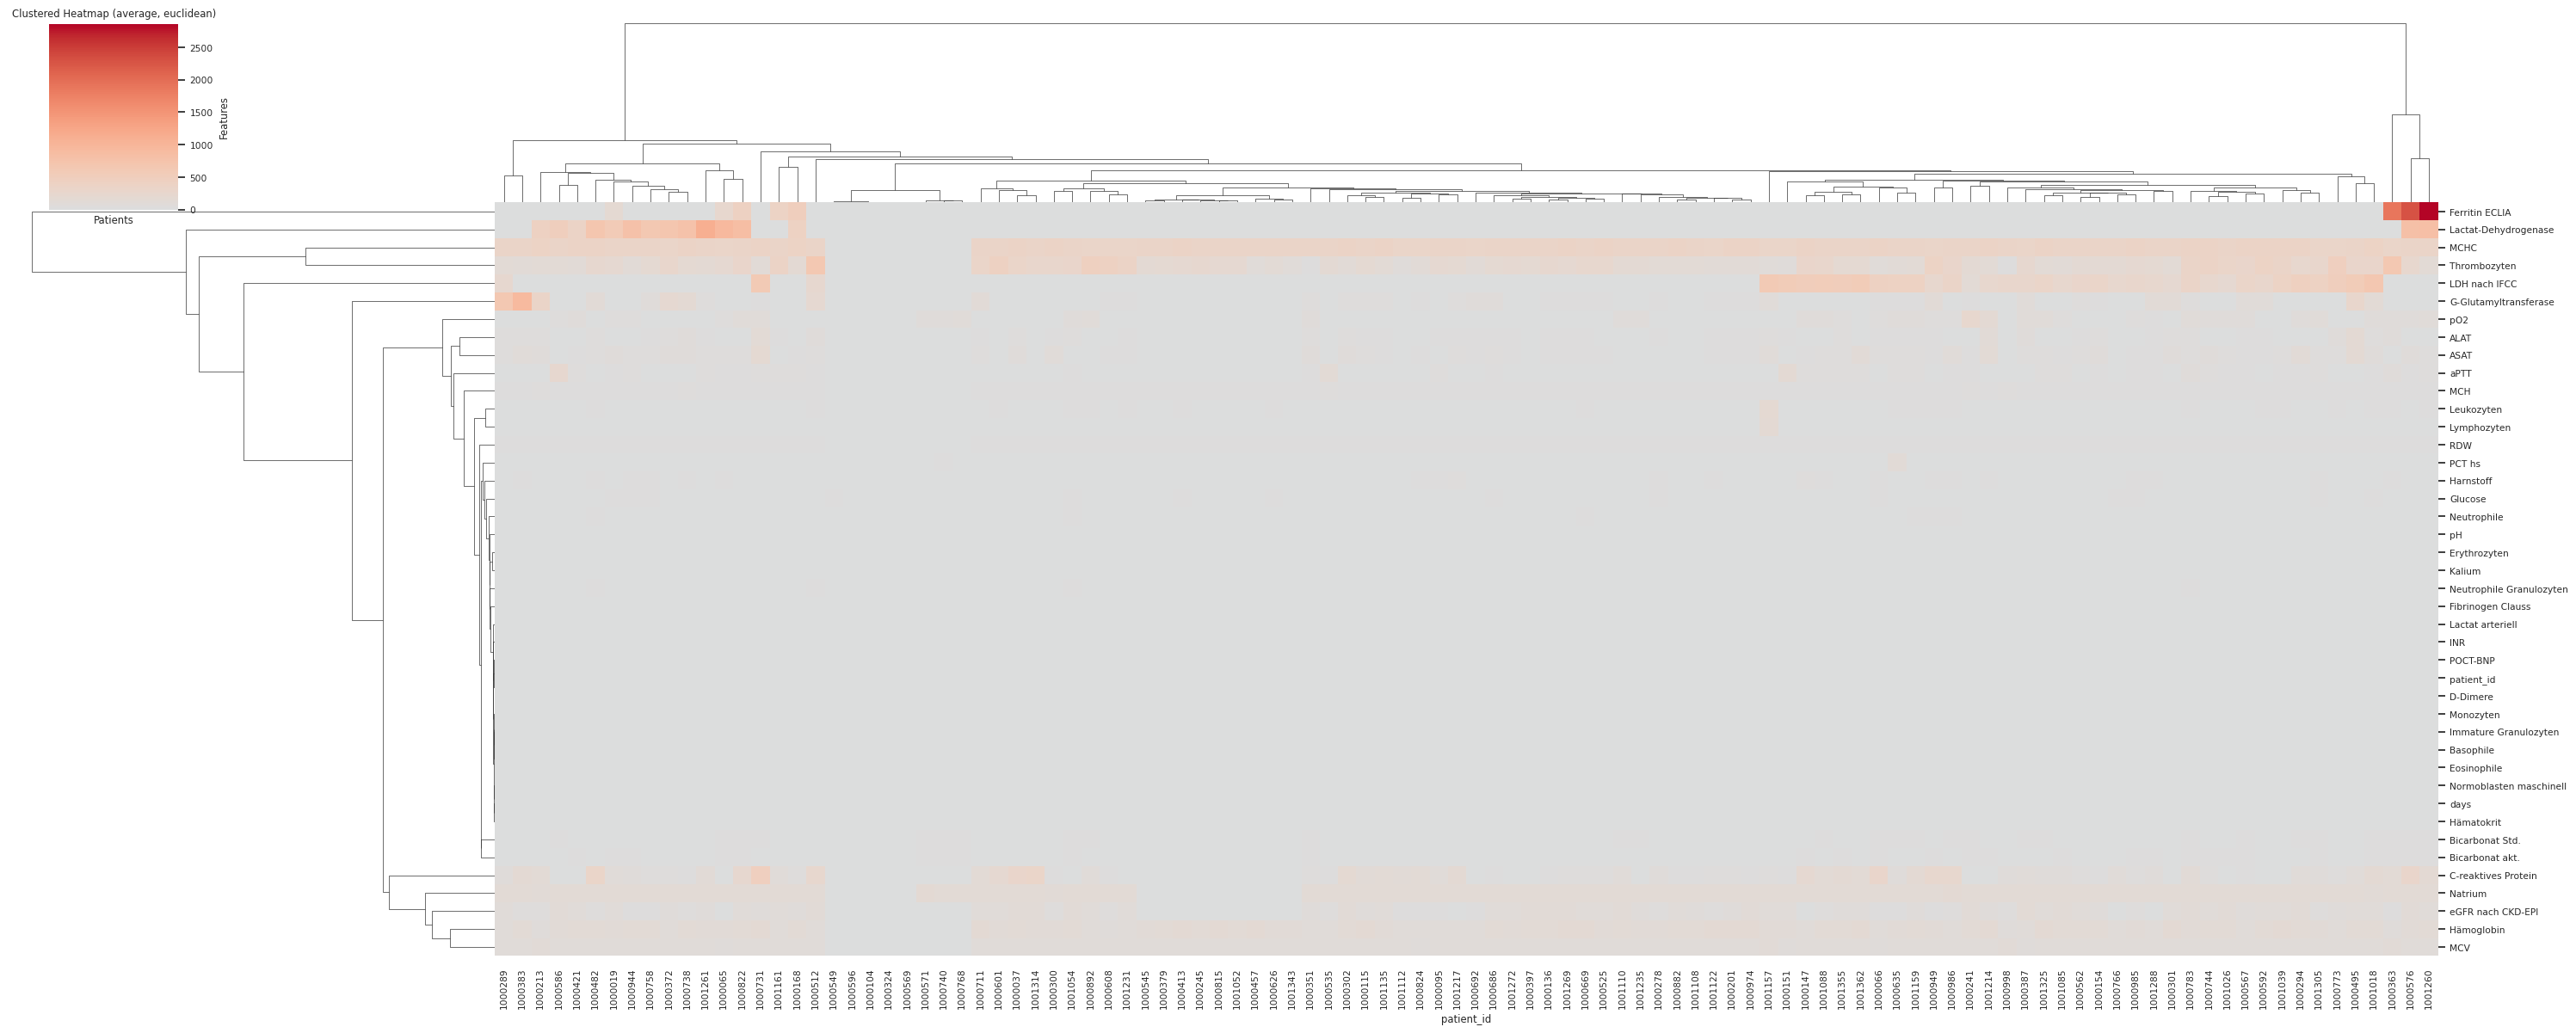

In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy
import seaborn as sns

def hierarchical_clustering(df, method='average', metric='euclidean', figsize=(12, 8), center=10):
    # Set NaN values to 0
    df = df.fillna(0)

    # Extract the feature columns and sample data
    feature_names = df.columns
    samples = df.values

    # Extract patients ids
    patient_ids = df.index.values

    # Standardize the data before calculating distances
    scaler = StandardScaler()
    scaled_samples = scaler.fit_transform(samples)

    # Calculate pairwise Euclidean distances
    similarities = hierarchy.linkage(scaled_samples, method=method, metric=metric)

    # Create a hierarchical clustering dendrogram
    plt.figure(figsize=figsize)
    hierarchy.dendrogram(similarities, labels=patient_ids, orientation='top', leaf_font_size=8)
    plt.title(f'Hierarchical Clustering Dendrogram ({method}, {metric})')
    plt.xlabel('Patients')
    plt.ylabel('Distance')
    plt.show()

    # Create a clustered heatmap using seaborn with patients on the x-axis and features on the y-axis
    sns.set(font_scale=0.7)
    plt.figure(figsize=figsize)
    sns.clustermap(df.T, method=method, metric=metric, cmap='coolwarm', figsize=figsize, center=center)
    plt.title(f'Clustered Heatmap ({method}, {metric})')
    plt.xlabel('Patients')
    plt.ylabel('Features')
    plt.show()

# Set the day range to be selected
init_day = 0
end_day = 2

# Load the list of laboratory features
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_parameter_grouping.csv')
df_lab_features = pd.read_csv(filename, sep=',', header=0)

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, f'116_plcp_lab_markers_day-{init_day}.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Set the 'df' columns in the order of the 'df_lab_features'
df = df.reindex(columns=df_lab_features['lab_parameter'].tolist())

# Set NaN values to 0
df = df.fillna(-1)

# Call the hierarchical_clustering function
hierarchical_clustering(df, method='average', metric='euclidean', figsize=(30, 12), center=10)

## Computing the PCA to visualize data patterns among potential long COVID patients (N = 116)

Number of NaN values: 0
Number of infinite values: 0


<Figure size 1500x1000 with 0 Axes>

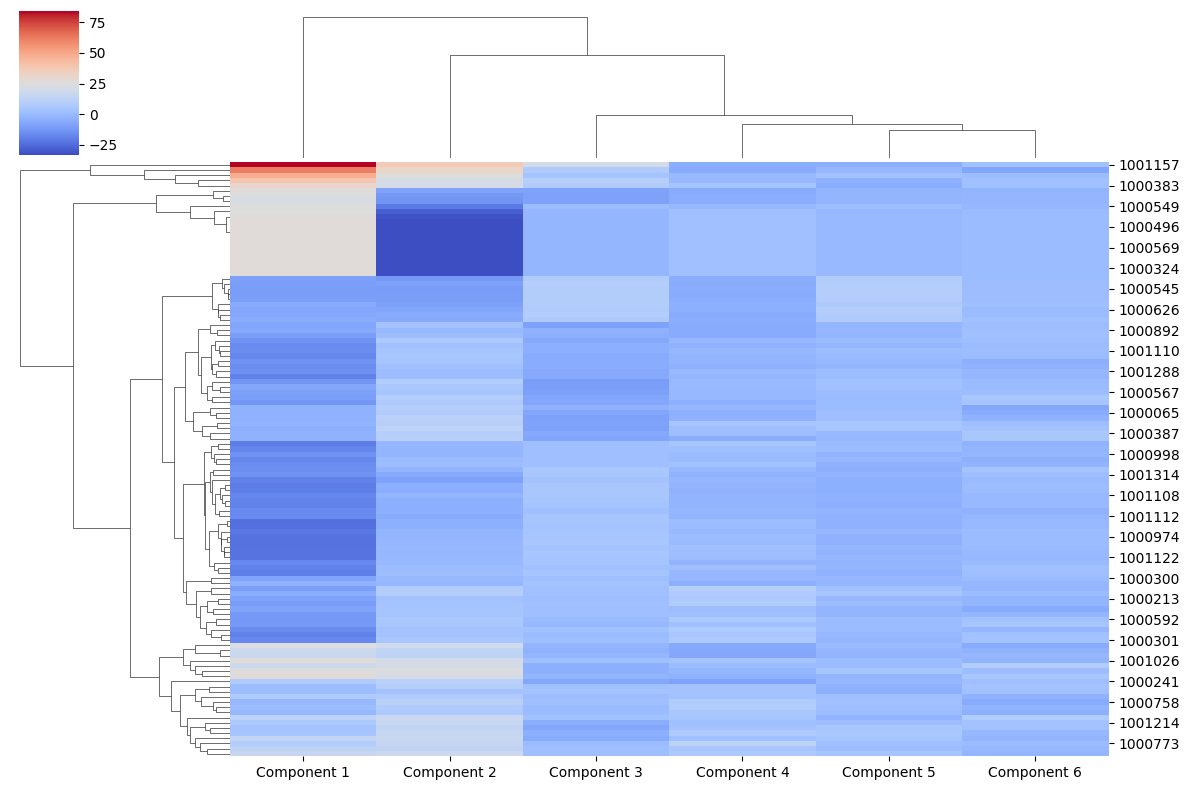

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Extract the feature columns and sample data
feature_names = df.columns
samples = df.values

# Extract patients ids
patient_ids = df.index.values

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Calculate pairwise Euclidean distances
similarities = euclidean_distances(scaled_samples)

# Debugging: Output non-finite values in the similarities matrix
nan_count = np.sum(np.isnan(similarities))
inf_count = np.sum(np.isinf(similarities))
print("Number of NaN values:", nan_count)
print("Number of infinite values:", inf_count)

# Replace NaN with infinity
similarities[np.isnan(similarities)] = np.inf

# Multidimensional scaling
seed = np.random.RandomState(seed=3)
mds = PCA(n_components=6, random_state=seed)  # Using 6 components
pos = mds.fit_transform(similarities)

# Create a DataFrame with the MDS positions and patient IDs
mds_df = pd.DataFrame(pos, columns=[f'Component {i+1}' for i in range(6)], index=patient_ids)

# Set up the matplotlib figure, make it big!
plt.figure(figsize=(15, 10))

# Create a cluster map using seaborn
# sns.clustermap(mds_df, cmap='viridis', method='average', metric='euclidean', figsize=(12, 8))

## Stablish 0 as the center of the heatmap
sns.clustermap(mds_df, cmap='coolwarm', method='average', metric='euclidean', figsize=(12, 8), center=25)

plt.show()

/tmp/ipykernel_40900/1962119126.py:33: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  patient_linkage = hierarchy.linkage(similarities, method='average', metric='euclidean')
/tmp/ipykernel_40900/1962119126.py:53: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  feature_linkage = hierarchy.linkage(feature_similarities, method='average', metric='euclidean')


<Figure size 1500x1000 with 0 Axes>

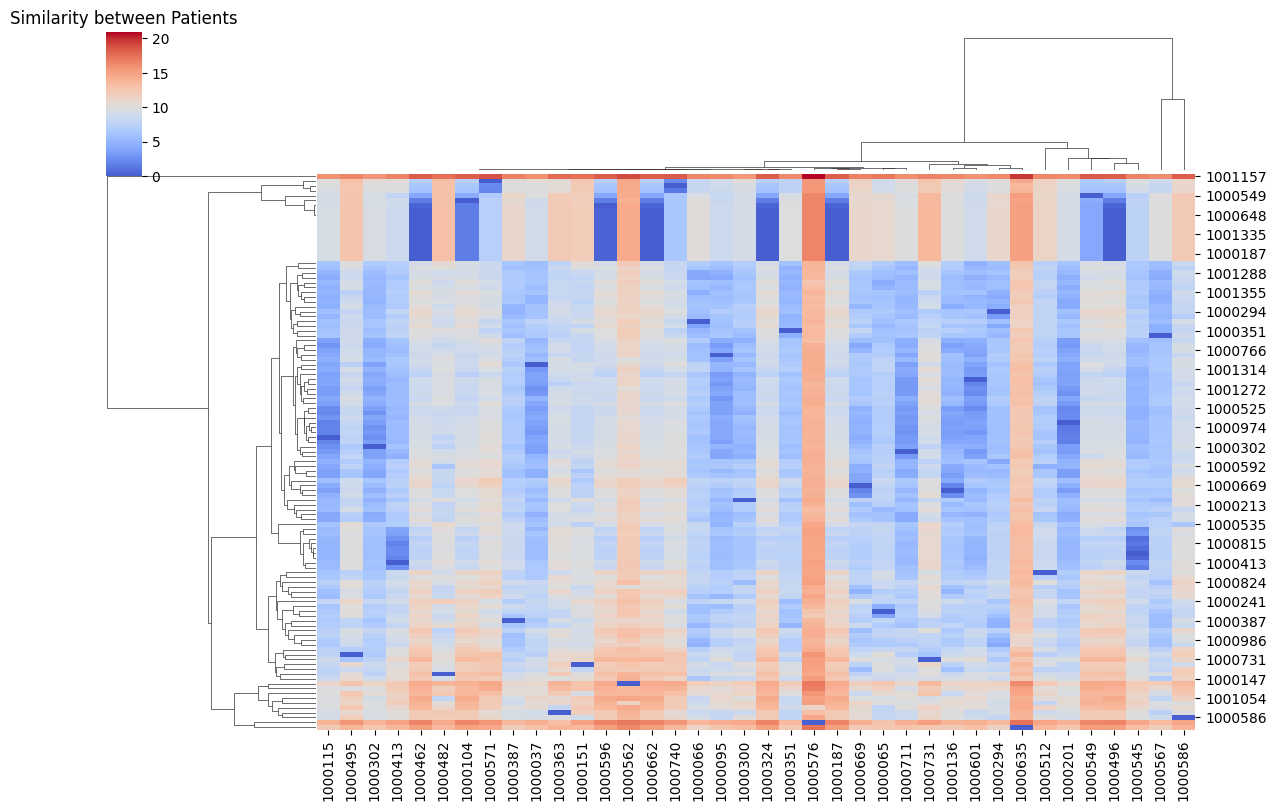

Sorted Feature Names: Index(['Hämatokrit', 'Monozyten', 'Normoblasten maschinell',
       'Immature Granulozyten', 'Basophile', 'Eosinophile', 'Lactat arteriell',
       'INR', 'Neutrophile Granulozyten', 'pH', 'Neutrophile', 'Erythrozyten',
       'Kalium', 'PCT hs', 'Harnstoff', 'Glucose', 'Bicarbonat Std.',
       'Bicarbonat akt.', 'RDW', 'Leukozyten', 'Lymphozyten', 'aPTT', 'MCH',
       'ALAT', 'pO2', 'ASAT', 'G-Glutamyltransferase', 'Hämoglobin', 'Natrium',
       'MCV', 'eGFR', 'Ferritin', 'MCHC', 'Lactat-Dehydrogenase',
       'Thrombozyten', 'LDH', 'Fibrinogen Clauss', 'D-Dimere'],
      dtype='object')


In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import euclidean_distances
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Extract the feature columns and sample data
feature_names = df.columns
samples = df.values

# Extract patients ids
patient_ids = df.index.values

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Calculate pairwise Euclidean distances
similarities = euclidean_distances(scaled_samples)

# Replace NaN with infinity
similarities[np.isnan(similarities)] = np.inf

# Calculate linkage for hierarchical clustering of patients
patient_linkage = hierarchy.linkage(similarities, method='average', metric='euclidean')

# Get the order of patients based on the clustering
patient_order = hierarchy.leaves_list(patient_linkage)

# Sort patient IDs according to the clustering order
sorted_patient_ids = patient_ids[patient_order]

# Create a DataFrame with the similarities and sorted patient IDs
# similarities_df = pd.DataFrame(similarities, columns=sorted_patient_ids, index=sorted_patient_ids)
# similarities_df = pd.DataFrame(similarities, columns=sorted_patient_ids, index=sorted_patient_ids)
similarities_df = pd.DataFrame(similarities, columns=patient_ids, index=patient_ids)

# Calculate the similarity matrix for features
feature_similarities = euclidean_distances(samples.T)

# Replace NaN with infinity
feature_similarities[np.isnan(feature_similarities)] = np.inf

# Calculate linkage for hierarchical clustering of features
feature_linkage = hierarchy.linkage(feature_similarities, method='average', metric='euclidean')

# Get the order of features based on the clustering
feature_order = hierarchy.leaves_list(feature_linkage)

# Sort feature names according to the clustering order
sorted_feature_names = feature_names[feature_order]

# Set up the matplotlib figure, make it big!
plt.figure(figsize=(15, 10))

# Create a cluster map using seaborn
sns.clustermap(similarities_df, cmap='coolwarm', row_cluster=True, col_cluster=True, center=10,
               row_linkage=patient_linkage, col_linkage=feature_linkage,
               figsize=(12, 8), cbar_pos=(0.02, 0.8, 0.03, 0.18))

# Add sorted feature names to the plot
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Similarity between Patients")

# Show the plot
plt.show()

# Display sorted feature names
print("Sorted Feature Names:", sorted_feature_names)